In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils import load, dump, distill, categories
from evaluate import eval, Evaluator
from os import getcwd
from tqdm import tqdm
import torch

root = f'{getcwd()}/..'
path = lambda p: f'{root}/../out/{p}'

In [2]:
testset = load(f'{root}/data/testset.json')

In [3]:
def evaluate(predict):    
    y_true = []
    y_pred = []

    for pr in tqdm(testset):
        title = pr['title']
        pcat = predict(title)
        tcat = pr['category']

        y_true.append(tcat)
        y_pred.append(pcat)
    
    eval(y_true, y_pred)

def progress(model):
    ev = Evaluator(path(model))
    ev.plot_progress()
    evaluate(ev.predict)

def compare(*models):
    model_files = [*map(path, models)]
    evaluators = [*map(Evaluator, model_files)]
    Evaluator.compare(*evaluators)

In [42]:
print(testset[0].keys())

dict_keys(['category', 'number', 'title', 'labels', 'state', 'pull_request', 'body', 'commits', 'target'])


## Let's evaluate the transformer classifiers

### Frozen baseline results for each architecture
DistilBERT and CodeBERTa showing best base config results

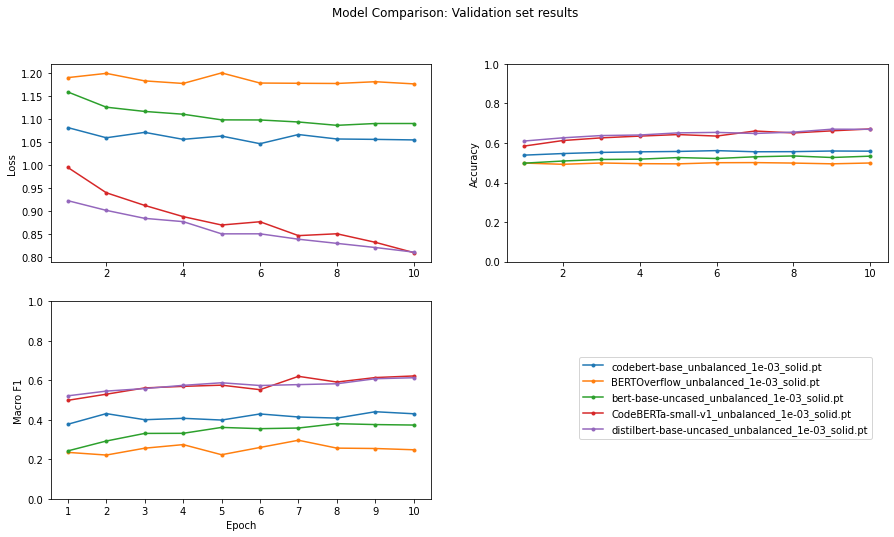

In [3]:
compare(
    'codebert-base_unbalanced_1e-03_solid.pt',
    'BERTOverflow_unbalanced_1e-03_solid.pt',
    'bert-base-uncased_unbalanced_1e-03_solid.pt',
    'CodeBERTa-small-v1_unbalanced_1e-03_solid.pt',
    'distilbert-base-uncased_unbalanced_1e-03_solid.pt',
)

### Balanced VS unbalanced training data

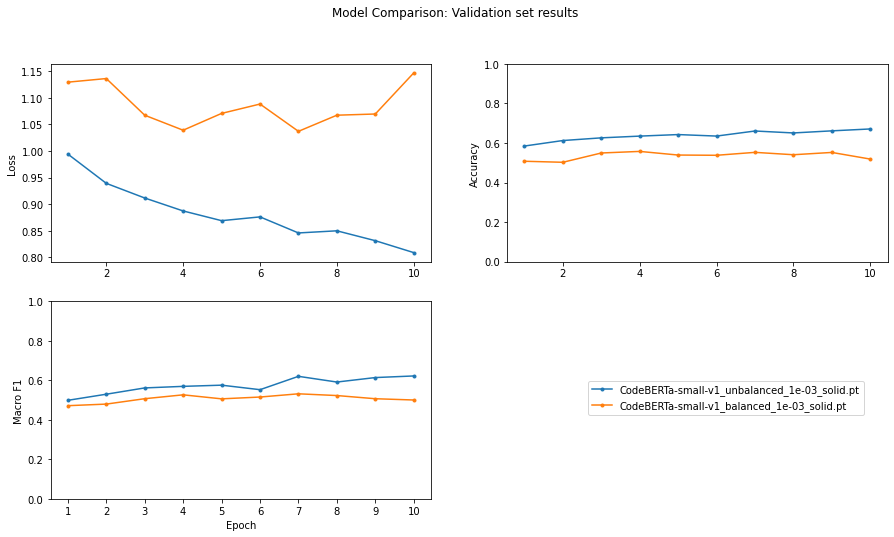

In [4]:
compare(
    'CodeBERTa-small-v1_unbalanced_1e-03_solid.pt',
    'CodeBERTa-small-v1_balanced_1e-03_solid.pt',
)

### Thaw impact CodeBERTa
Unfreezing one layer seems to do wonders, any more than that increases the loss dramatically.

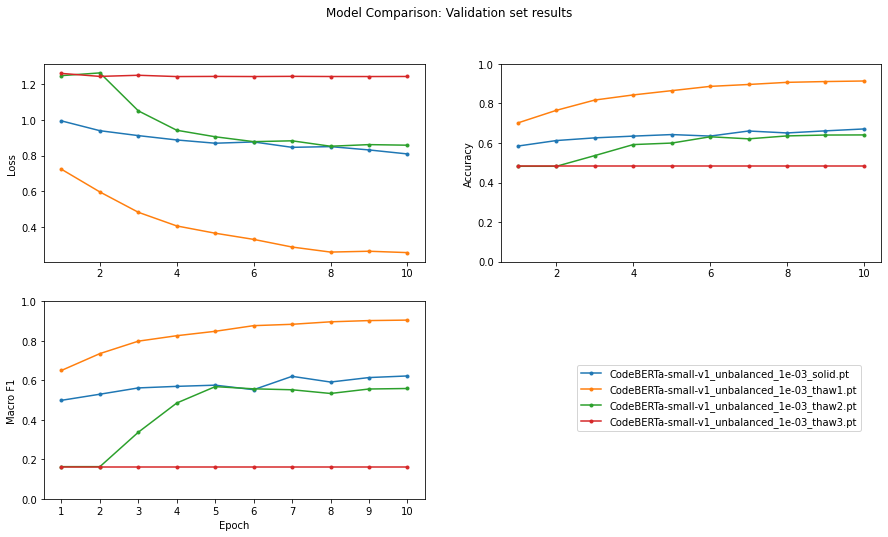

In [5]:
compare(
    'CodeBERTa-small-v1_unbalanced_1e-03_solid.pt',
    'CodeBERTa-small-v1_unbalanced_1e-03_thaw1.pt',
    'CodeBERTa-small-v1_unbalanced_1e-03_thaw2.pt',
    'CodeBERTa-small-v1_unbalanced_1e-03_thaw3.pt',
)

### Thaw impact DistilBERT
Unfreezing a couple of layers seems to decrease loss segnificantly

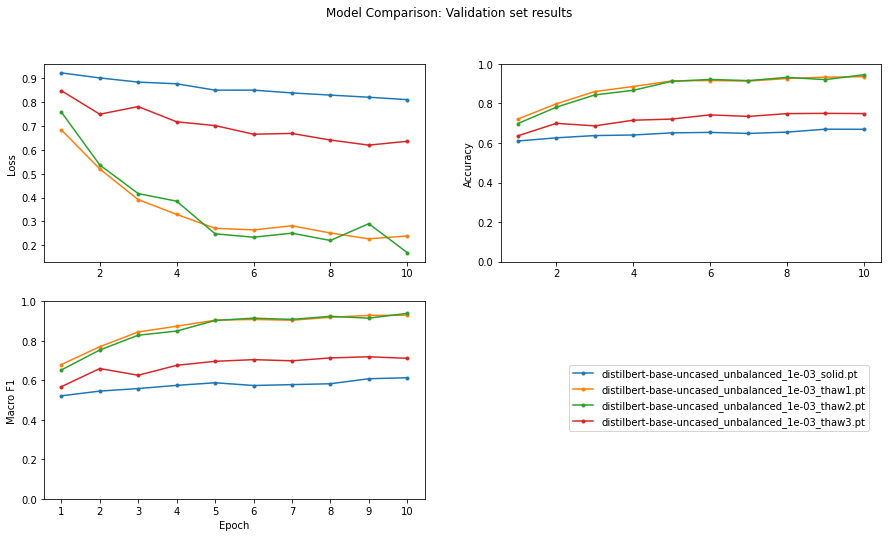

In [6]:
compare(
    'distilbert-base-uncased_unbalanced_1e-03_solid.pt',
    'distilbert-base-uncased_unbalanced_1e-03_thaw1.pt',
    'distilbert-base-uncased_unbalanced_1e-03_thaw2.pt',
    'distilbert-base-uncased_unbalanced_1e-03_thaw3.pt',
)

### DistilBERT t2 vs CodeBERTA t1

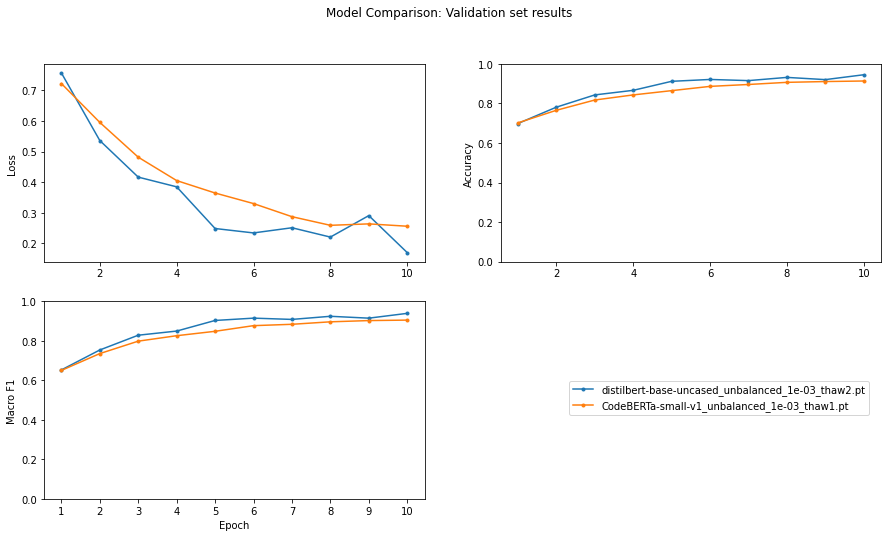

In [7]:
compare('distilbert-base-uncased_unbalanced_1e-03_thaw2.pt', 'CodeBERTa-small-v1_unbalanced_1e-03_thaw1.pt',)

## BEST YET

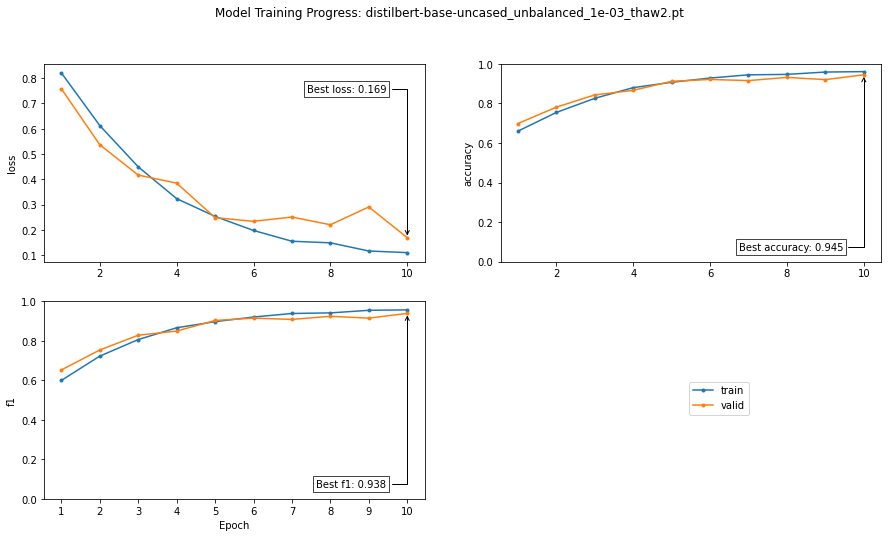

100%|██████████| 504/504 [00:18<00:00, 27.40it/s]

                precision    recall  f1-score   support

      fix-bugs       0.33      0.87      0.48        76
  new-features       0.50      0.35      0.41       148
 documentation       0.67      0.65      0.66        52
non-functional       0.66      0.43      0.52       228

      accuracy                           0.50       504
     macro avg       0.54      0.58      0.52       504
  weighted avg       0.56      0.50      0.50       504

[[66  3  2  5]
 [55 52  5 36]
 [ 8  1 34  9]
 [72 48 10 98]]


In [46]:
progress('distilbert-base-uncased_unbalanced_1e-03_thaw2.pt')

# Extended data models

In [53]:
def evaluate(predict):    
    y_true = []
    y_pred = []
    
    emstr = lambda v: v if v else ''

    for pr in tqdm(testset):
        title = pr['title']
        body = pr['body']
        commits = [*map(lambda c: c['commit']['message'], pr['commits'])]
        inp = ' '.join([title, emstr(body), *commits])
        pcat = predict(inp)
        tcat = pr['category']

        y_true.append(tcat)
        y_pred.append(pcat)
    
    eval(y_true, y_pred)

def progress(model):
    ev = Evaluator(path(model))
    ev.plot_progress()
    evaluate(ev.predict)

## Base config architecture comparison

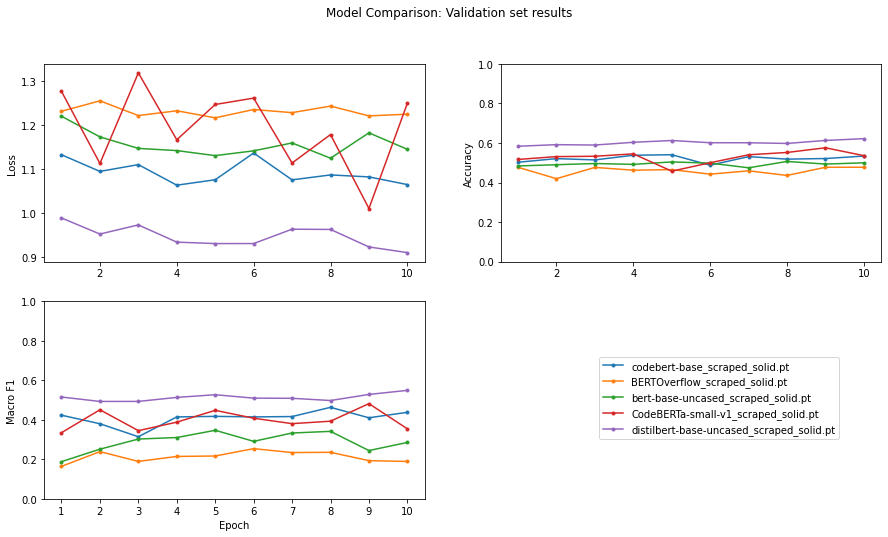

In [17]:
compare(
    'codebert-base_scraped_solid.pt',
    'BERTOverflow_scraped_solid.pt',
    'bert-base-uncased_scraped_solid.pt',
    'CodeBERTa-small-v1_scraped_solid.pt',
    'distilbert-base-uncased_scraped_solid.pt',
)

## DistilBERT

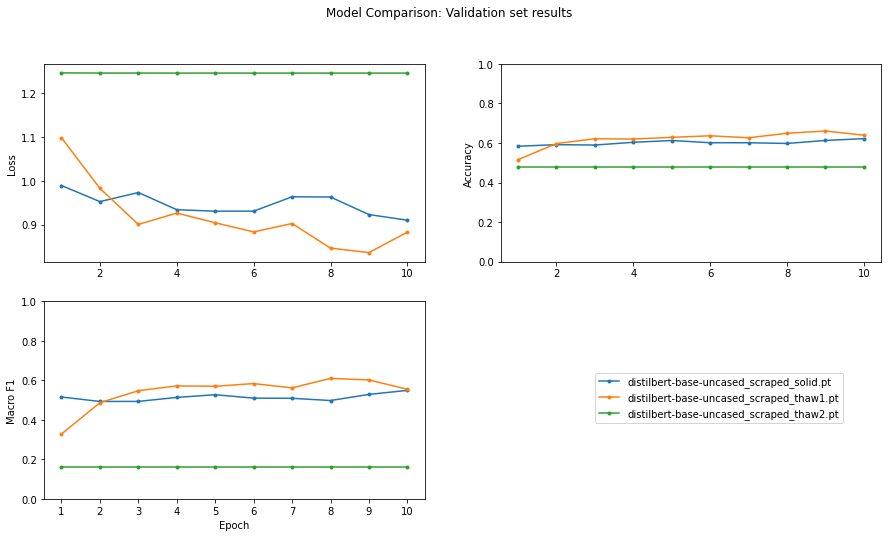

In [14]:
compare(
    'distilbert-base-uncased_scraped_solid.pt',
    'distilbert-base-uncased_scraped_thaw1.pt',
    'distilbert-base-uncased_scraped_thaw2.pt',
)

## CodeBERTA

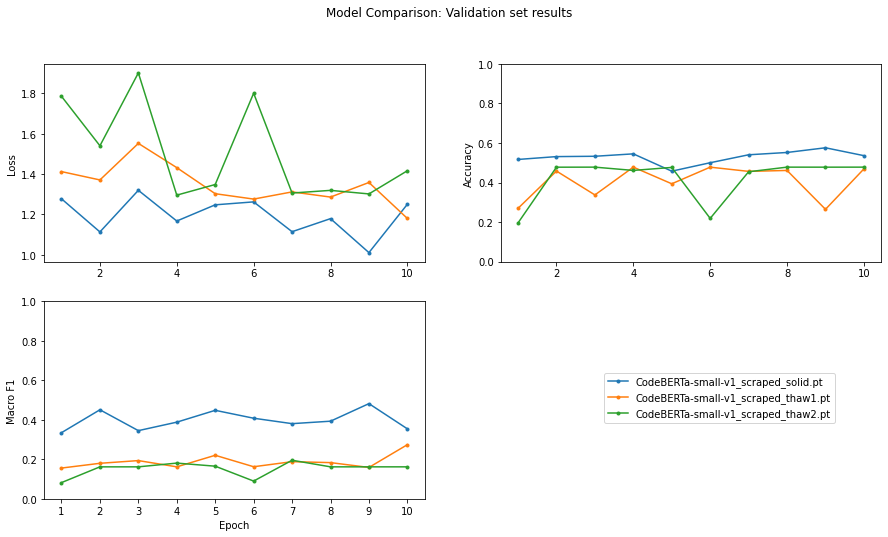

In [16]:
compare(
    'CodeBERTa-small-v1_scraped_solid.pt',
    'CodeBERTa-small-v1_scraped_thaw1.pt',
    'CodeBERTa-small-v1_scraped_thaw2.pt',
)

## Experimenting with learning rate (CodeBERTa)

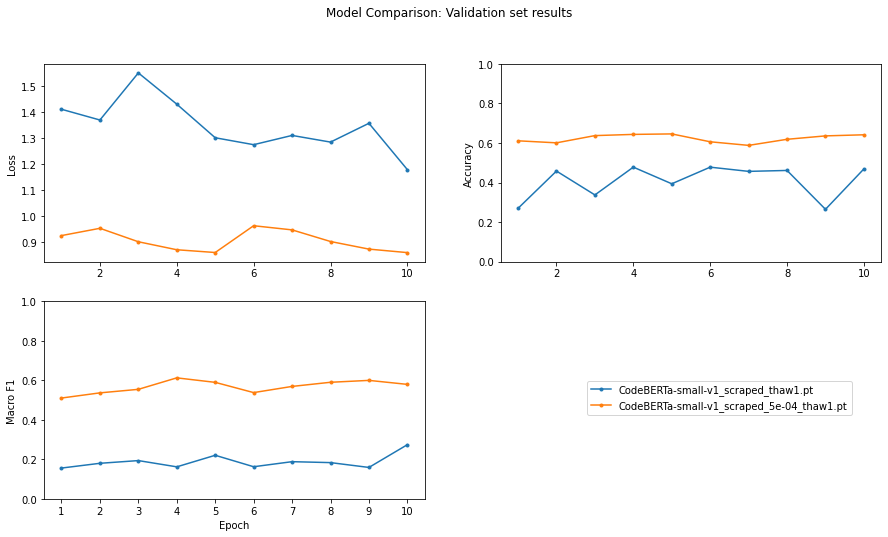

In [21]:
compare(
    'CodeBERTa-small-v1_scraped_thaw1.pt',
    'CodeBERTa-small-v1_scraped_5e-04_thaw1.pt',
)

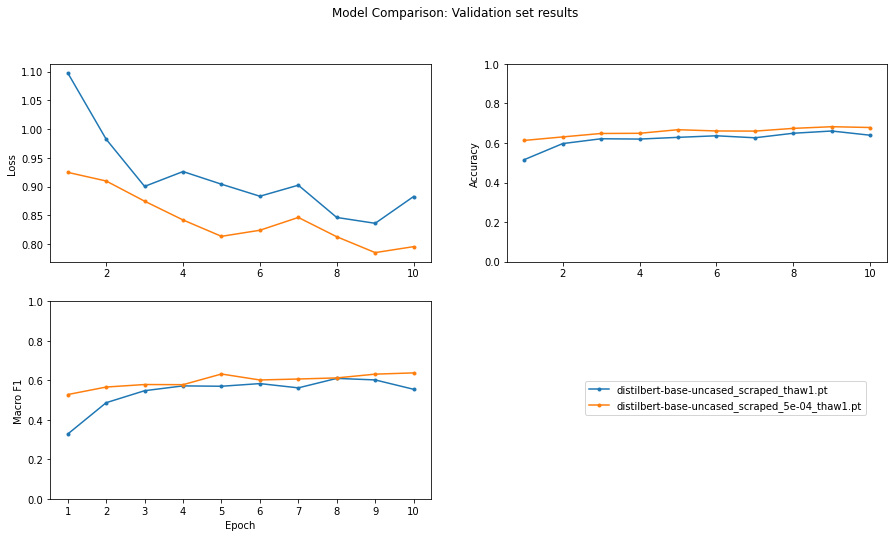

In [32]:
compare(
    'distilbert-base-uncased_scraped_thaw1.pt',
    'distilbert-base-uncased_scraped_5e-04_thaw1.pt',
)

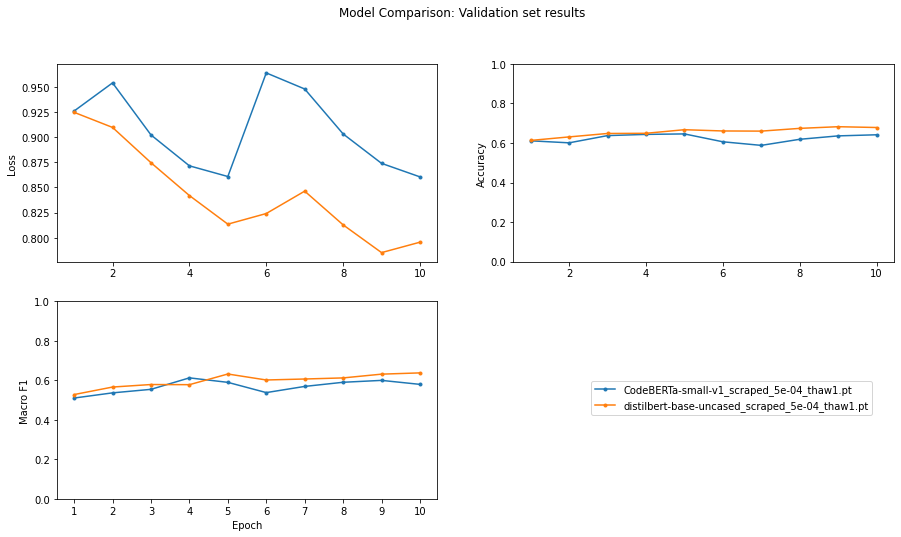

In [23]:
compare(
    'CodeBERTa-small-v1_scraped_5e-04_thaw1.pt',
    'distilbert-base-uncased_scraped_5e-04_thaw1.pt',
)

# Solid distilBERT

In [ ]:
#0.62

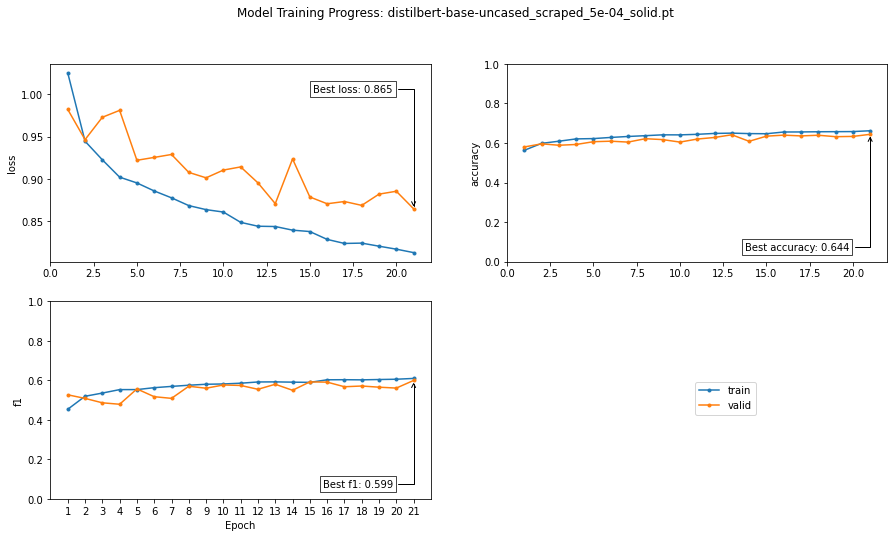

100%|██████████| 504/504 [01:56<00:00,  4.32it/s]

                precision    recall  f1-score   support

      fix-bugs       0.42      0.86      0.56        76
  new-features       0.54      0.66      0.59       148
 documentation       0.80      0.46      0.59        52
non-functional       0.65      0.39      0.48       228

      accuracy                           0.55       504
     macro avg       0.60      0.59      0.56       504
  weighted avg       0.60      0.55      0.54       504

[[65  6  0  5]
 [10 98  2 38]
 [21  2 24  5]
 [60 76  4 88]]


In [50]:
progress('distilbert-base-uncased_scraped_5e-04_solid.pt')

## distilBERT one thawed layer

In [ ]:
#0.54?

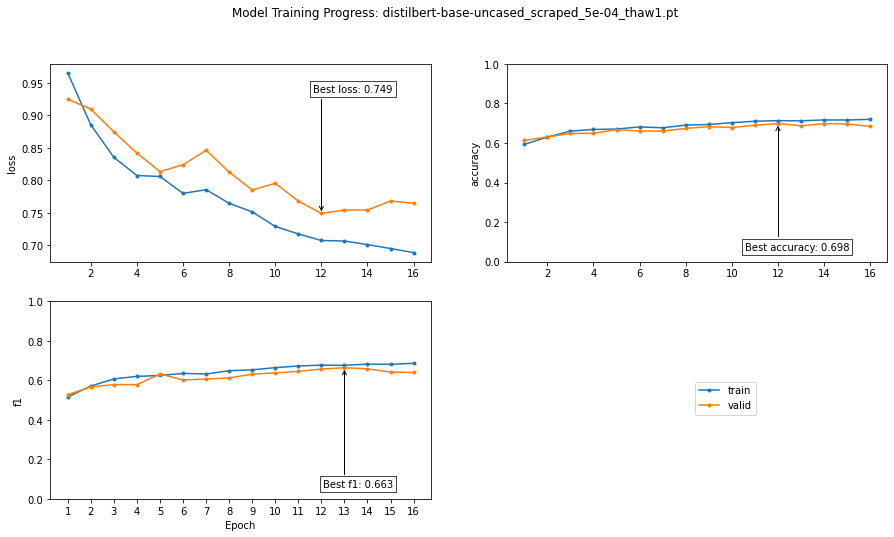

100%|██████████| 504/504 [02:50<00:00,  2.96it/s]

                precision    recall  f1-score   support

      fix-bugs       0.42      0.83      0.56        76
  new-features       0.57      0.49      0.53       148
 documentation       0.80      0.71      0.76        52
non-functional       0.61      0.48      0.53       228

      accuracy                           0.56       504
     macro avg       0.60      0.63      0.59       504
  weighted avg       0.59      0.56      0.56       504

[[ 63   3   0  10]
 [ 23  73   0  52]
 [  5   1  37   9]
 [ 58  52   9 109]]


In [48]:
progress('distilbert-base-uncased_scraped_5e-04_thaw1.pt')

# Per-file Diff Data Models

In [10]:
def evaluate(predict):    
    y_true = []
    y_pred = []

    for pr in tqdm(testset):
        for diff in pr['diffs']:
            pcat = predict(diff)
            tcat = pr['category']

            y_true.append(tcat)
            y_pred.append(pcat)
    
    eval(y_true, y_pred)

def progress(model):
    ev = Evaluator(path(model))
    ev.plot_progress()
    evaluate(ev.predict)

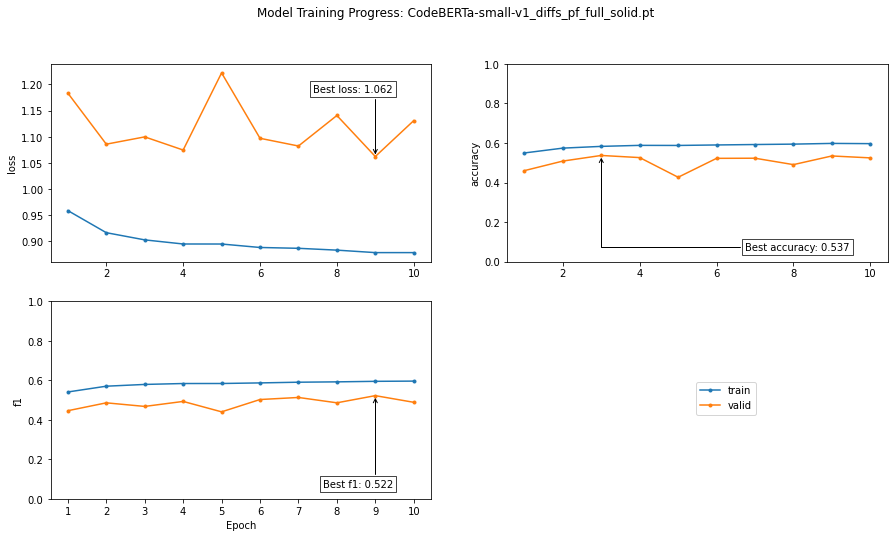

100%|██████████| 505/505 [33:40<00:00,  4.00s/it]  

                precision    recall  f1-score   support

      fix-bugs       0.05      0.44      0.09       252
  new-features       0.39      0.61      0.47      2288
 documentation       0.47      0.10      0.17       185
non-functional       0.49      0.02      0.03      3210

      accuracy                           0.27      5935
     macro avg       0.35      0.29      0.19      5935
  weighted avg       0.43      0.27      0.21      5935

[[ 111  141    0    0]
 [ 859 1385    9   35]
 [  20  121   19   25]
 [1231 1909   12   58]]


In [11]:
progress('CodeBERTa-small-v1_diffs_pf_full_solid.pt')

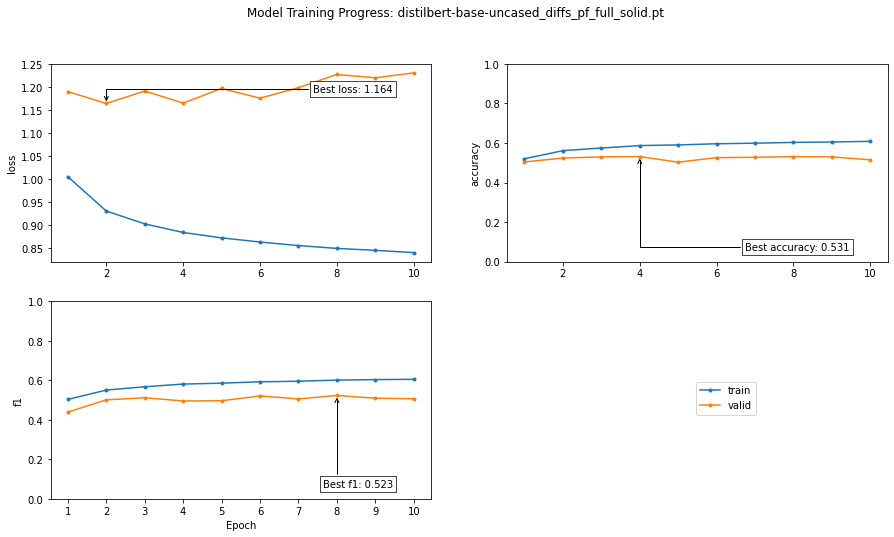

100%|██████████| 505/505 [33:30<00:00,  3.98s/it]  

                precision    recall  f1-score   support

      fix-bugs       0.07      0.58      0.12       252
  new-features       0.44      0.14      0.21      2288
 documentation       0.20      0.28      0.23       185
non-functional       0.58      0.49      0.53      3210

      accuracy                           0.35      5935
     macro avg       0.32      0.37      0.27      5935
  weighted avg       0.49      0.35      0.38      5935

[[ 147   26    2   77]
 [ 886  323   97  982]
 [  21   21   52   91]
 [1172  360  110 1568]]


In [12]:
progress('distilbert-base-uncased_diffs_pf_full_solid.pt')

# Per-pr Diff Data Models

In [9]:
def evaluate(predict):    
    y_true = []
    y_pred = []

    for pr in tqdm(testset):
        inp = distill('\n'.join(pr['diffs']))
        pcat = predict(inp)
        tcat = pr['category']

        y_true.append(tcat)
        y_pred.append(pcat)
    
    eval(y_true, y_pred)

def progress(model):
    ev = Evaluator(path(model))
    ev.plot_progress()
    evaluate(ev.predict)

## Base config architecture comparison

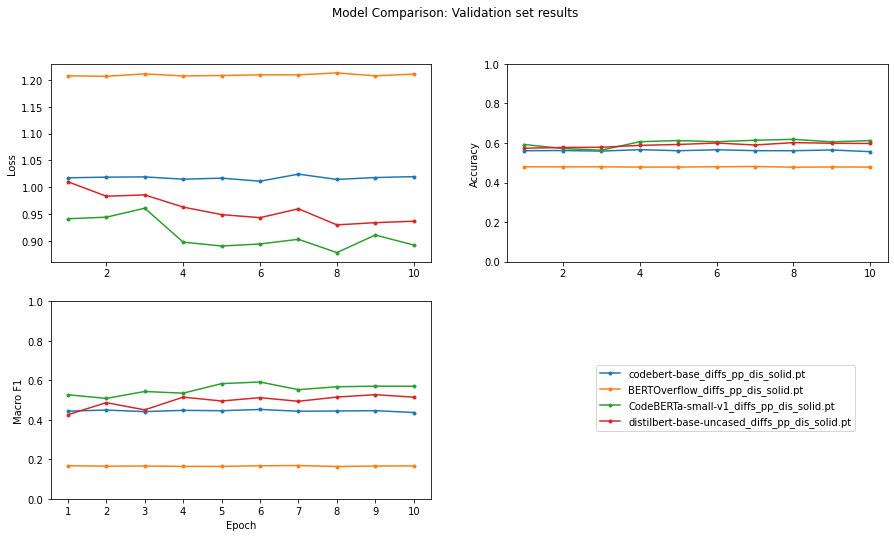

In [10]:
compare(
    'codebert-base_diffs_pp_dis_solid.pt',
    'BERTOverflow_diffs_pp_dis_solid.pt',
    'CodeBERTa-small-v1_diffs_pp_dis_solid.pt',
    'distilbert-base-uncased_diffs_pp_dis_solid.pt',
)

## CodeBERTa thaw impact

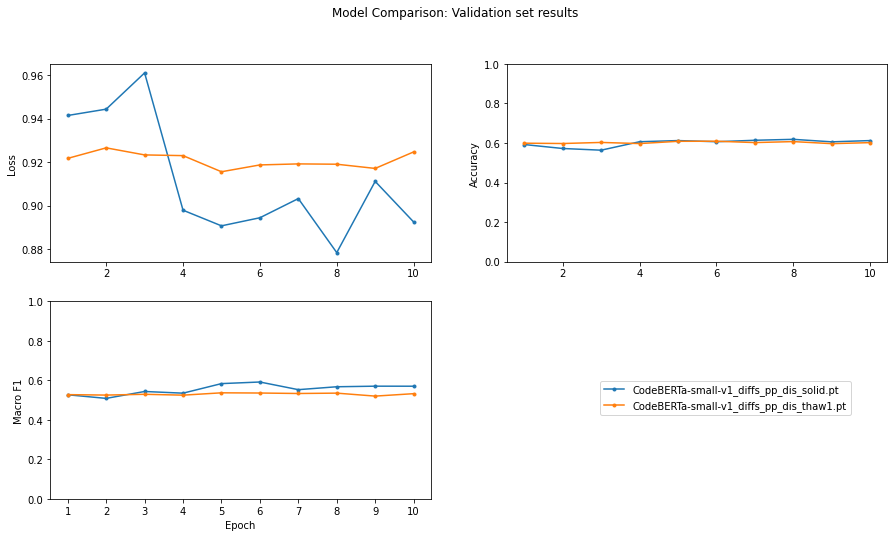

In [11]:
compare(
    'CodeBERTa-small-v1_diffs_pp_dis_solid.pt',
    'CodeBERTa-small-v1_diffs_pp_dis_thaw1.pt',
)

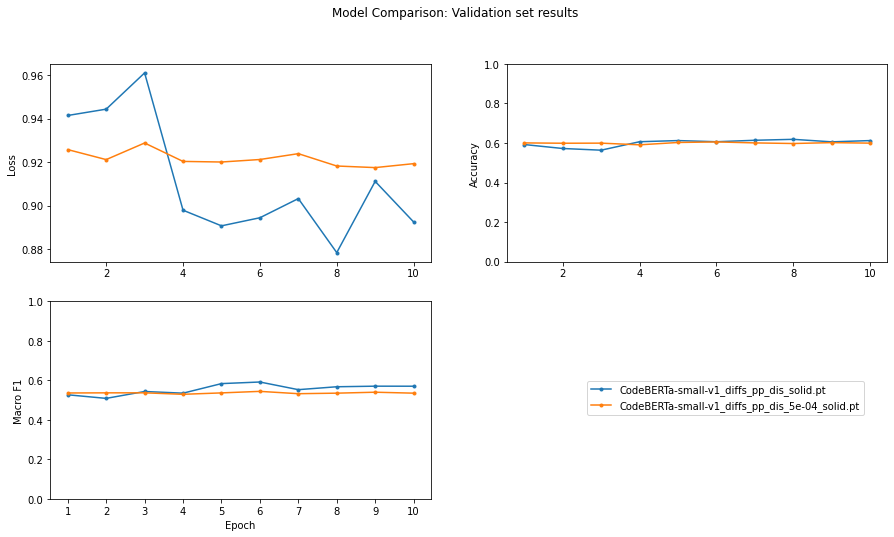

In [17]:
compare(
    'CodeBERTa-small-v1_diffs_pp_dis_solid.pt',
    'CodeBERTa-small-v1_diffs_pp_dis_5e-04_solid.pt'
)

## Meta-Classifier results

In [5]:
class LogisticRegression(torch.nn.Module):

    def __init__(self, inp, out):

        super(LogisticRegression, self).__init__()

        self.linear = torch.nn.Linear(inp, out)

    def forward(self, x):

        outputs = self.linear(x)

        return outputs

meta = LogisticRegression(8, 4)
PATH = f'{root}/../out/meta_classifier2.pt'
cp = torch.load(PATH, map_location=torch.device('cpu'))
meta.load_state_dict(cp['best_state']['model_state_dict'])
meta.eval()

def evaluate(nl_predict, diff_predict):    
    y_true = []
    y_pred = []
    
    emstr = lambda v: v if v else ''

    for pr in tqdm(testset):
        # Diff input
        diff = distill('\n'.join(pr['diffs']))
        
        # NL input
        title = pr['title']
        body = pr['body']
        commits = [*map(lambda c: c['commit']['message'], pr['commits'])]
        nl = ' '.join([title, emstr(body), *commits])
        
        # Combine
        m1 = nl_predict(nl, raw=True)
        m2 = diff_predict(diff, raw=True)
        stacked = torch.cat((m1, m2), -1)
        
        # Meta model output
        outputs = meta(stacked)
        catidx = torch.argmax(outputs, dim=-1)
        
        pcat = categories[catidx]
        tcat = pr['category']

        y_true.append(tcat)
        y_pred.append(pcat)
    
    eval(y_true, y_pred)

def progress(nl_model, diff_model):
    nl_ev = Evaluator(path(nl_model))
    diff_ev = Evaluator(path(diff_model))
    evaluate(nl_ev.predict, diff_ev.predict)

In [8]:
# meta trained on valid
progress('distilbert-base-uncased_scraped_5e-04_thaw1.pt', 'CodeBERTa-small-v1_diffs_pp_dis_solid.pt')

100%|██████████| 505/505 [04:24<00:00,  1.91it/s]

                precision    recall  f1-score   support

      fix-bugs       0.44      0.88      0.59        76
  new-features       0.54      0.74      0.63       149
 documentation       0.87      0.77      0.82        52
non-functional       0.72      0.33      0.46       228

      accuracy                           0.58       505
     macro avg       0.64      0.68      0.62       505
  weighted avg       0.64      0.58      0.56       505

[[ 67   4   0   5]
 [ 17 110   1  21]
 [  7   1  40   4]
 [ 60  87   5  76]]


In [6]:
# meta trained on train
progress('distilbert-base-uncased_scraped_5e-04_thaw1.pt', 'CodeBERTa-small-v1_diffs_pp_dis_solid.pt')

100%|██████████| 505/505 [04:11<00:00,  2.01it/s]

                precision    recall  f1-score   support

      fix-bugs       0.46      0.88      0.60        76
  new-features       0.56      0.68      0.61       149
 documentation       0.85      0.77      0.81        52
non-functional       0.69      0.39      0.50       228

      accuracy                           0.59       505
     macro avg       0.64      0.68      0.63       505
  weighted avg       0.63      0.59      0.58       505

[[ 67   3   0   6]
 [ 17 101   1  30]
 [  7   1  40   4]
 [ 56  76   6  90]]
